## Netflix - Data Exploration and Visualisation

### Problem Statement 
Deciding on Which Type of Shows/Movies to Include

#### Analysing Basic Metrics

In [30]:
import datetime
start_time = datetime.datetime.now()  # Setup a timestamp for the start of the script

In [31]:
# Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [32]:
# Retreiving the Netflix dataset
# netflix_df = pd.read_csv('netflix.csv')
netflix_df = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv')
netflix_df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


In [33]:
rows, columns = netflix_df.shape
print(f'The dataset has {rows} rows and {columns} columns')

The dataset has 8807 rows and 12 columns


In [34]:
# Quick Overview of the dataset
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [35]:
# Finding the percentage of Null Values
netflix_df.isnull().sum()/netflix_df.shape[0]*100

show_id          0.000000
type             0.000000
title            0.000000
director        29.908028
cast             9.367549
country          9.435676
date_added       0.113546
release_year     0.000000
rating           0.045418
duration         0.034064
listed_in        0.000000
description      0.000000
dtype: float64

<span style="font-size: 14px;">
<strong> Inference: </strong> 30% of Directors, 10 % of Cast and Country and 0.1% of Added Date values are not available
<br>
<strong>Action Item: </strong>Dropping the NA fields or filling the default value is not recommended. Since it's a kind of grouping NA values together. To resolve that the imputation needs to be done
</span>

In [36]:
# Columns having nested values and their count
for col in netflix_df.columns:
    if(netflix_df[col].dtype == 'object'):
        print(f'{col} : {netflix_df[col].str.contains(",").sum()}')

show_id : 0
type : 0
title : 138
director : 614
cast : 7101
country : 1320
date_added : 8797
rating : 0
duration : 0
listed_in : 6787
description : 6448


<span style="font-size: 14px">
<strong>Inference:</strong> 
<ul>
<li>Assuming Title and Date Added are not having the nested values based on the analysis did on sample data.</li>
<li>Nested Columns: Director, Cast, Country, Listed In/Genre </li>
<li>Other Columns needs a pre-processing because of a nested values</li>
</ul>
</span>

In [37]:
netflix_df.nunique()

show_id         8807
type               2
title           8807
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

<span style="font-size: 14px">
<strong>Inference:</strong> 
<ul>
<li>Title and Show ID can be used as a primary key since all the values are unique.</li>
<li>Only Movies and Series Type data are available.</li>
<li>The shows are categorized for 17 different Category of people (No Nested Values available)</li>
</ul>
</span>

#### Pre-Processing of Data

In [38]:
# Dropping Description column - Not required for analysis without NLP
netflix_df.drop(['description'], axis=1, inplace=True)

In [39]:
# remove strings from the duration column values and make it int datatype
netflix_df['duration'] = netflix_df['duration'].str.replace('Seasons', '').str.replace('Season', '').str.replace('min', '').str.strip()
netflix_df['duration'] = netflix_df['duration'].astype(float)

In [40]:
# Change the datatype of the date_added column to datetime
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'].str.strip())

In [41]:
# Setting Show ID as index
netflix_df.set_index('show_id', inplace=True)
netflix_df.head(2)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in
show_id,,,,,,,,,,
s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90.0,Documentaries
s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2.0,"International TV Shows, TV Dramas, TV Mysteries"


In [42]:
# Function to convert Nested Values to Rows
def convert_nested_columns_to_rows(df, column):
    nested_df = df[column].str.split(',', expand=True)
    nested_df = pd.DataFrame(nested_df.stack()).reset_index()
    nested_df.columns = ['show_id', f'{column}_no', column]
    nested_df.drop(columns=[f'{column}_no'], inplace=True)
    return nested_df

# Nested Columns - Director, Cast, Country, Listed In
director_df = convert_nested_columns_to_rows(netflix_df, 'director')
cast_df = convert_nested_columns_to_rows(netflix_df, 'cast')
country_df = convert_nested_columns_to_rows(netflix_df, 'country')
listed_in_df = convert_nested_columns_to_rows(netflix_df, 'listed_in')

# Merging the Nested Columns with the main dataset
director_cast_df = pd.merge(director_df, cast_df, on='show_id', how='outer')
country_listed_in_df = pd.merge(country_df, listed_in_df, on='show_id', how='outer')
merged_df = pd.merge(director_cast_df, country_listed_in_df, on='show_id', how='outer')
merged_df.drop_duplicates(inplace=True)
merged_df.head()


,show_id,director,cast,country,listed_in
0,s1,Kirsten Johnson,NaN,United States,Documentaries
1,s10,Theodore Melfi,Melissa McCarthy,United States,Comedies
2,s10,Theodore Melfi,Melissa McCarthy,United States,Dramas
3,s10,Theodore Melfi,Chris O'Dowd,United States,Comedies
4,s10,Theodore Melfi,Chris O'Dowd,United States,Dramas


In [43]:
# Filtering the main dataset without nested columns
filterd_netflix_df = netflix_df.loc[:, netflix_df.columns.difference(['director', 'cast', 'country', 'listed_in'])]

# Merging the main dataset with the merged dataset
flattened_netflix_df = pd.merge(filterd_netflix_df, merged_df, on='show_id', how='left')
flattened_netflix_df.head(2)

,show_id,date_added,duration,rating,release_year,title,type,director,cast,country,listed_in
0,s1,2021-09-25,90.0,PG-13,2020,Dick Johnson Is Dead,Movie,Kirsten Johnson,NaN,United States,Documentaries
1,s2,2021-09-24,2.0,TV-MA,2021,Blood & Water,TV Show,NaN,Ama Qamata,South Africa,International TV Shows


<span style="font-size: 14px">
<strong>Inference:</strong> 
All the Nested Values are Flattened and created a new dataset
</span>

In [44]:
# Filling missing values in the 'Duration' column with the median value, grouped by the 'type',"listed_in", "release_year" column
flattened_netflix_df['duration'] = flattened_netflix_df.groupby(['type',"listed_in", "release_year"])['duration'].transform(lambda x: x.fillna(x.median()))

# Filling missing values in the 'Rating' column with the mode value, grouped by the 'type', "listed_in", "release_year" column
flattened_netflix_df['rating'] = flattened_netflix_df.groupby(['type', "listed_in", "release_year"])['rating'].transform(lambda x: x.fillna(x.mode()[0]))

# Filling missing values in the "Date Added" column with the median value, grouped by the 'type', "listed_in", "release_year", "duration" column
flattened_netflix_df['date_added'] = flattened_netflix_df.groupby(['type', "listed_in", "release_year", "duration"])['date_added'].transform(lambda x: x.fillna(x.median()) if x.median() is not None else x)
flattened_netflix_df['date_added'] = flattened_netflix_df.groupby(['type', "listed_in", "release_year"])['date_added'].transform(lambda x: x.fillna(x.median()) if x.median() is not None else x)
flattened_netflix_df['date_added'] = flattened_netflix_df.groupby(['type', "listed_in"])['date_added'].transform(lambda x: x.fillna(x.median()) if x.median() is not None else x)

# Filling missing values in the "Country" column with the mode value, grouped by the 'type', "listed_in", "rating" column
flattened_netflix_df['country'] = flattened_netflix_df.groupby(['type', "listed_in", "rating"])['country'].transform(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x)
# Still some Values are missing and filling those values in the "Country" column with the mode value, grouped by the 'type', "listed_in" column
flattened_netflix_df['country'] = flattened_netflix_df.groupby(['type', "listed_in"])['country'].transform(lambda x: x.fillna(x.mode()[0]))


# Filling missing values in the "Cast" column with the mode value, grouped by the 'type', "listed_in", "rating" column
flattened_netflix_df["cast"] = flattened_netflix_df.groupby(['type', "listed_in", "country", "rating"])['cast'].transform(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x)
# Still some Values are missing and filling missing values in the "Cast" column with the mode value, grouped by the 'type', "listed_in", "rating" column
flattened_netflix_df["cast"] = flattened_netflix_df.groupby(['type', "listed_in", "country"])['cast'].transform(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x)
# Still some Values are missing and filling missing values in the "Cast" column with the mode value, grouped by the 'type', "listed_in", "rating" column
flattened_netflix_df["cast"] = flattened_netflix_df.groupby(['type', "listed_in"])['cast'].transform(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x)


# Filling missing values in the "director" column with the mode value, grouped by the 'type', "listed_in", "rating" column
flattened_netflix_df["director"] = flattened_netflix_df.groupby(['type', "listed_in", "country", "rating", "cast", "duration", "release_year"])['director'].transform(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x)
flattened_netflix_df["director"] = flattened_netflix_df.groupby(['type', "listed_in", "country", "rating", "duration" , "release_year"])['director'].transform(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x)
flattened_netflix_df['director'] = flattened_netflix_df.groupby(['type', "listed_in", "country", "release_year"])['director'].transform(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x)
flattened_netflix_df['director'] = flattened_netflix_df.groupby(['type', "listed_in", "country"])['director'].transform(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x)
flattened_netflix_df['director'] = flattened_netflix_df.groupby(['type', "listed_in"])['director'].transform(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x)
flattened_netflix_df['director'] = flattened_netflix_df.groupby(['type'])['director'].transform(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x)

flattened_netflix_df.isna().sum()


c:\Pthon3117\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

c:\Pthon3117\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

c:\Pthon3117\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

c:\Pthon3117\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

c:\Pthon3117\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

c:\Pthon3117\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

c:\Pthon3117\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

c:\Pthon3117\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

c:\Pthon3117\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

c:\Pthon3117\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning:

Mean of emp

show_id         0
date_added      0
duration        0
rating          0
release_year    0
title           0
type            0
director        0
cast            0
country         0
listed_in       0
dtype: int64

#### Non-Graphical Analysis

In [45]:
#  Describe the Numerical Columns in dataset
movies_df = flattened_netflix_df[flattened_netflix_df['type'] == 'Movie']
shows_df = flattened_netflix_df[flattened_netflix_df['type'] == 'TV Show']

In [46]:
stack_1 = movies_df[movies_df.select_dtypes(['int', 'float', 'datetime']).columns].describe()
stack_1.columns = [f'{col}_Movies' for col in stack_1.columns]
stack_2 = shows_df[shows_df.select_dtypes(['int', 'float', 'datetime']).columns].describe()
stack_2.columns = [f'{col}_Shows' for col in stack_2.columns]

# stack horizontally
pd.concat([stack_1, stack_2], axis=1)

,date_added_Movies,duration_Movies,release_year_Movies,date_added_Shows,duration_Shows,release_year_Shows
count,145910,145910.000000,145910.000000,56148,56148.000000,56148.000000
mean,2019-06-14 21:48:07.747241984,106.839792,2012.131574,2019-07-01 00:10:27.826458368,1.928101,2016.874902
min,2008-01-01 00:00:00,3.000000,1942.000000,2008-02-04 00:00:00,1.000000,1925.000000
25%,2018-07-01 00:00:00,93.000000,2010.000000,2018-05-04 00:00:00,1.000000,2016.000000
50%,2019-08-29 00:00:00,104.000000,2016.000000,2019-10-04 00:00:00,1.000000,2018.000000
75%,2020-08-28 00:00:00,119.000000,2018.000000,2020-10-15 00:00:00,2.000000,2020.000000
max,2021-09-25 00:00:00,312.000000,2021.000000,2021-09-24 00:00:00,17.000000,2021.000000
std,NaN,24.711015,9.815637,NaN,1.811729,5.069625


<span style="font-size:14px">
    <strong>Inference for Movies</strong>
    <ul>
        <li>Entire Data is in the range of 01-01-2008 and 25-09-2021</li>
        <li>On an average, Movie will take 106 minutes</li>
        <li>50% of the movies were added on 2019 which means it took 11 years(2008-2019) in starting stage to include in netflix. In other words, more number of movies were included in the recent years (2 Years)</li>
    </ul>
    <strong>Inference for TV Shows</strong>
    <ul>
        <li>Same like Movies, TV shows also included in the same range (2008-2021). If we compare dates, Movies were included first.</li>
        <li>On an average, all the TV Shows have 2 seasons</li>
        <li>50% of the Shows were included with the last 3 years</li>
    </ul>
</span>

In [47]:
# Describe the Categorical Columns in dataset
stack_1 = movies_df[movies_df.select_dtypes(['object']).columns].describe()
stack_1.columns = [f'{col}_Movies' for col in stack_1.columns]
stack_2 = shows_df[shows_df.select_dtypes(['object']).columns].describe()
stack_2.columns = [f'{col}_Shows' for col in stack_2.columns]

# stack horizontally
pd.concat([stack_1, stack_2], axis=1)


,show_id_Movies,rating_Movies,title_Movies,type_Movies,director_Movies,cast_Movies,country_Movies,listed_in_Movies,show_id_Shows,rating_Shows,title_Shows,type_Shows,director_Shows,cast_Shows,country_Shows,listed_in_Shows
count,145910,145910,145910,145910,145910,145910,145910,145910,56148,56148,56148,56148,56148,56148,56148,56148
unique,6131,17,6131,1,4886,27879,187,37,2676,9,2676,1,300,15501,102,36
top,s7165,TV-MA,Kahlil Gibran's The Prophet,Movie,Martin Scorsese,Russell Simmons,United States,International Movies,s2554,TV-MA,The Eddy,TV Show,Danny Cannon,David Attenborough,United States,TV Dramas
freq,700,44016,700,145910,449,187,40806,27138,416,29913,416,56148,3486,157,14094,7956


<span style="font-size: 14px">
    <strong>Inference for Movies</strong>
    <ul>
        <li>There are 17 unique categories for the movies</li>
        <li>There are 4886 directors and 27879 Crew Member, who's movies were added into the Netflix</li>
        <li>There are 37 Genre of movies</li>
        <li>Top Director was Martin Scorsese and Top Country was US. Likewise, other top rated categories were listed in the table.</li>
    </ul>
    <strong>Inference for Shows</strong>
    <ul>
        <li>There are 9 unique categories for the shoes</li>
        <li>There are 300 directors and 15501 Crew Member, who's shoes were added into the Netflix</li>
        <li>There are 36 Genre of Shoes</li>
        <li>Top Director was Danny Cannon and Top Country was US. Likewise, other top rated categories were listed in the table.</li>
    </ul>
</span>

In [48]:
# Extracting the Unique Values in the dataset which is a part of describe function

movies_unique = movies_df.nunique()
shows_unique = shows_df.nunique()

# stack horizontally
unique_df = pd.concat([movies_unique, shows_unique], axis=1)
unique_df.columns = ['Movies', 'Shows']
unique_df

,Movies,Shows
show_id,6131,2676
date_added,1533,1012
duration,205,15
rating,17,9
release_year,73,46
title,6131,2676
type,1,1
director,4886,300
cast,27879,15501
country,187,102


<span style="font-size: 14px">
    <strong>Inference</strong>
    <ul>
        <li>Showing the unique count for all the fields</li>
        <li>There are 6131 Movies and 2676 TV Shows available in Netflix</li>
        <li>There are 4886 Movie Directors and 300 TV Show Directors who's contents were included in Netflix</li>
    </ul>
</span>

In [49]:
# Extracting the Highest number of Contents year wise
no_of_movies_df = netflix_df.loc[netflix_df["type"]=="Movie"]["release_year"].value_counts().head(1).head(1)
print(f'The year with the most number of movies released is {no_of_movies_df.index[0]} with {no_of_movies_df.values[0]} movies')

no_of_shows_df = netflix_df.loc[netflix_df["type"]=="TV Show"]["release_year"].value_counts().head(1).head(1)
print(f'The year with the most number of TV Shows released is {no_of_shows_df.index[0]} with {no_of_shows_df.values[0]} TV Shows')


# Extracting the most available Genre in Netflix
no_movies_genre = movies_df["listed_in"].value_counts().head(1)
print(f'The most available genre in Movies is "{no_movies_genre.index[0].strip()}" with {no_movies_genre.values[0]} movies')

no_shows_genre = shows_df["listed_in"].value_counts().head(1)
print(f'The most available genre in TV Shows is "{no_shows_genre.index[0].strip()}" with {no_shows_genre.values[0]} TV Shows')

The year with the most number of movies released is 2017 with 767 movies
The year with the most number of TV Shows released is 2020 with 436 TV Shows
The most available genre in Movies is "International Movies" with 27138 movies
The most available genre in TV Shows is "TV Dramas" with 7956 TV Shows


<span style="font-size: 14px">
    <strong>Inference</strong>
    <ul>
        <li>Extracted few information like Maximum number of movies release and their corresponding year</li>
        <li>In Movies type, 767 movies were included on 2017</li>
        <li>In TV Shows type, 436 shows were included on 2020</li>
        <li>In Movies type, "International Movies" is the major Genre with 27138 Movies</li>
        <li>In TV Shows type, "TV Dramas" is the major Genre with 7956 Movies</li>
    </ul>
</span>

#### Visual Analysis

##### Univariate Analysis

In [50]:
# Top 3 Directors, Genre, Country
top3_movies_directors = movies_df.groupby("director")["show_id"].nunique().sort_values(ascending=False).index[:10]
top3_movies_genre = movies_df.groupby("listed_in")["show_id"].nunique().sort_values(ascending=False).index[:10]
top3_movies_country = movies_df.groupby("country")["show_id"].nunique().sort_values(ascending=False).index[:10]

top3_movies_data = movies_df[(movies_df["director"].isin(top3_movies_directors)) & (movies_df["listed_in"].isin(top3_movies_genre)) & (movies_df["country"].isin(top3_movies_country))]
top3_movies_data.size


top3_shows_directors = shows_df.groupby("director")["show_id"].nunique().sort_values(ascending=False).index[:10]
top3_shows_genre = shows_df.groupby("listed_in")["show_id"].nunique().sort_values(ascending=False).index[:10]
top3_shows_country = shows_df.groupby("country")["show_id"].nunique().sort_values(ascending=False).index[:10]

top3_shows_data = shows_df[(shows_df["director"].isin(top3_shows_directors)) & (shows_df["listed_in"].isin(top3_shows_genre)) & (shows_df["country"].isin(top3_shows_country))]
top3_shows_data.size

# stack both the dataframes
top3_data = pd.concat([top3_movies_data, top3_shows_data], axis=0)
top3_data.head()

,show_id,date_added,duration,rating,release_year,title,type,director,cast,country,listed_in
1018,s42,2021-09-16,124.0,PG,1975,Jaws,Movie,Steven Spielberg,Roy Scheider,United States,Action & Adventure
1020,s42,2021-09-16,124.0,PG,1975,Jaws,Movie,Steven Spielberg,Roy Scheider,United States,Dramas
1021,s42,2021-09-16,124.0,PG,1975,Jaws,Movie,Steven Spielberg,Robert Shaw,United States,Action & Adventure
1023,s42,2021-09-16,124.0,PG,1975,Jaws,Movie,Steven Spielberg,Robert Shaw,United States,Dramas
1024,s42,2021-09-16,124.0,PG,1975,Jaws,Movie,Steven Spielberg,Richard Dreyfuss,United States,Action & Adventure


In [51]:
movies_grp_df = movies_df.groupby(['title', 'date_added']).size().reset_index(name='count')
fig = px.histogram(movies_grp_df, x="date_added", barmode='group')
fig.update_layout(title='Date_added Distribution in Movies', xaxis_title='Date Added', yaxis_title='Number of Movies')
fig.show()

shows_grp_df = shows_df.groupby(['title', 'date_added']).size().reset_index(name='count')
fig = px.histogram(shows_grp_df, x="date_added", barmode='group')
fig.update_layout(title='Date_added Distribution in TV Shows', xaxis_title='Date Added', yaxis_title='Number of TV Shows')
fig.show()

<span style="font-size: 14px">
    <strong>Histogram Inference</strong>
    <ul>
        <li>From the Movies Graph, more number of movies were added on November 2019 - December 2019 which was around 355</li>
        <li>From the TV Shows Graph, more number of shows were added on July 2021 - Augest 2021 which was around 149</li>
        <li>After the end of 2015, so many number of Movies and TV Shows were added drastically.</li>
        <li>There was a drop in adding a new contents in the Mid of 2018. But, after that, Netflix managed to increase the number of contents.</li>
    </ul>
</span>

In [52]:
shows_grp_df.head(10)

,title,date_added,count
0,#blackAF,2020-04-17,7
1,(Un)Well,2020-08-12,1
2,100 Days My Prince,2020-12-07,18
3,100 Humans,2020-03-13,6
4,100% Hotter,2019-11-01,12
5,12 Years Promise,2017-05-22,18
6,13 Reasons Why,2020-06-05,39
7,13 Reasons Why: Beyond the Reasons,2019-08-23,56
8,1983,2018-11-30,72
9,1994,2019-05-17,3


In [53]:
# shows_grp_df["listed_in"].value_counts().index[-11:-1:]

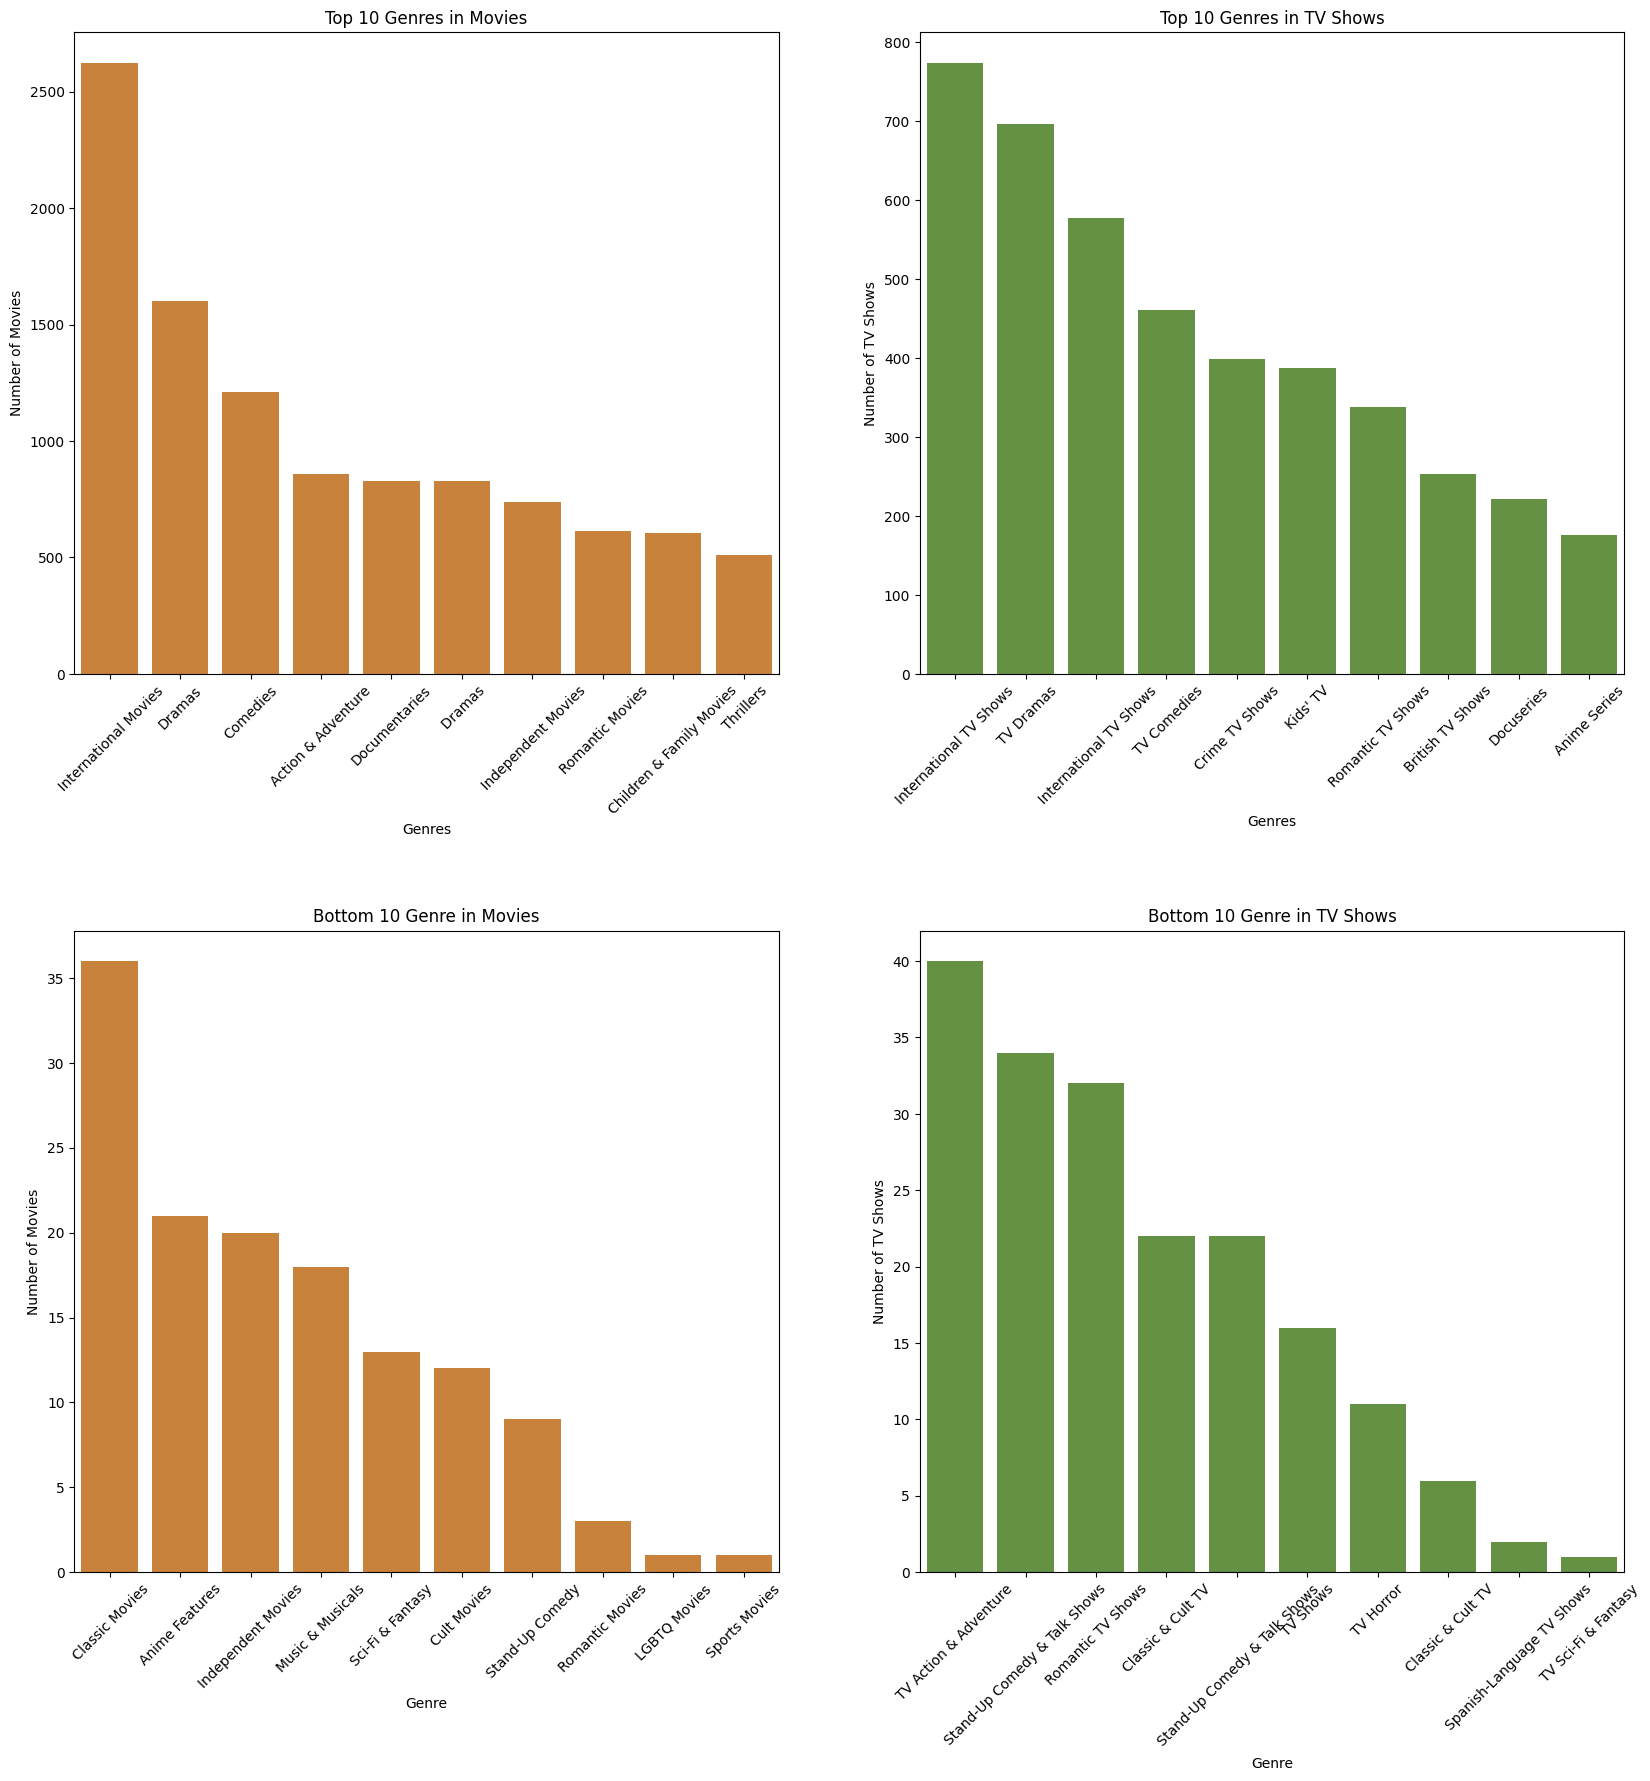

In [54]:
def draw_counterplot(data, x, title, xlabel, ylabel, color, start, end=None, step=None):
    sns.countplot(data=data, x=x, order=data[x].value_counts().index[start:end:step], color=color)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plt.figure(figsize=(20, 20))
movies_grp_df = movies_df.groupby(['title', 'listed_in']).size().reset_index(name='count')
movies_grp_df.sort_values(by='count', ascending=False, inplace=True)
plt.subplot(2,2,1)
draw_counterplot(movies_grp_df, 'listed_in', 'Top 10 Genres in Movies', 'Genres', 'Number of Movies', '#e08225', 0, 10, 1)

shows_grp_df = shows_df.groupby(['title', 'listed_in']).size().reset_index(name='count')
shows_grp_df.sort_values(by='count', ascending=False, inplace=True)
plt.subplot(2,2,2)
draw_counterplot(shows_grp_df, 'listed_in', 'Top 10 Genres in TV Shows', 'Genres', 'Number of TV Shows', '#639e38', 0, 10, 1)

plt.subplots_adjust(hspace=0.4)  # Adjusts the height between subplots

plt.subplot(2,2,3)
draw_counterplot(movies_grp_df, 'listed_in', 'Bottom 10 Genre in Movies', 'Genre', 'Number of Movies', '#e08225', -10)

plt.subplot(2,2,4)
draw_counterplot(shows_grp_df, 'listed_in', 'Bottom 10 Genre in TV Shows', 'Genre', 'Number of TV Shows', '#639e38', -10)

plt.show()


<span style="font-size: 14px">
    <strong>Count Plot Inference</strong>
    <ul>
        <li>Graph shows the top and bottom 10 Genre of Movies and TV Shows</li>
        <li>International Movies Genre is the top most one available in Movies Category</li>
        <li>International TV Shows Genre is the top most one available in TV Shows Category</li>
        <li>Sports Movies is the least available one in Movies Category</li>
        <li>TV Sci-Fi & Fantasy is the least available one in the TV Show Category</li>
    </ul>
</span>

In [55]:
flattened_netflix_df.head()

,show_id,date_added,duration,rating,release_year,title,type,director,cast,country,listed_in
0,s1,2021-09-25,90.0,PG-13,2020,Dick Johnson Is Dead,Movie,Kirsten Johnson,Aaron Guy,United States,Documentaries
1,s2,2021-09-24,2.0,TV-MA,2021,Blood & Water,TV Show,Lee Yoon-jung,Ama Qamata,South Africa,International TV Shows
2,s2,2021-09-24,2.0,TV-MA,2021,Blood & Water,TV Show,Danny Cannon,Ama Qamata,South Africa,TV Dramas
3,s2,2021-09-24,2.0,TV-MA,2021,Blood & Water,TV Show,Rob Seidenglanz,Ama Qamata,South Africa,TV Mysteries
4,s2,2021-09-24,2.0,TV-MA,2021,Blood & Water,TV Show,Lee Yoon-jung,Khosi Ngema,South Africa,International TV Shows


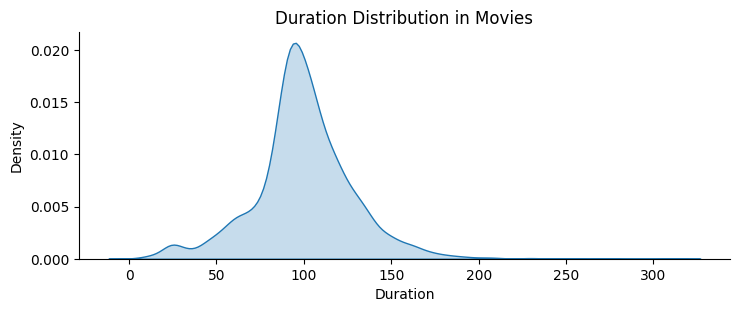

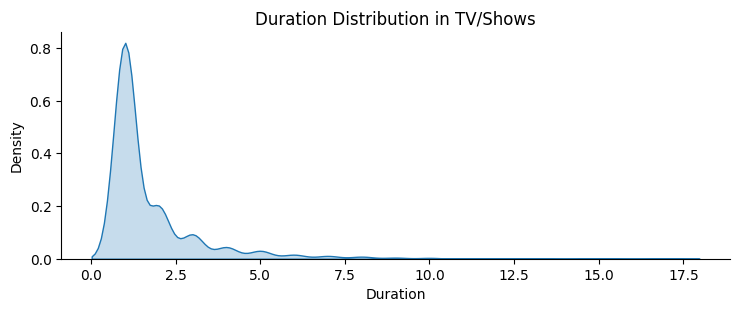

In [56]:
movies_grp_df = movies_df.groupby(['title', 'duration']).size().reset_index(name='count')
fig = sns.displot(data=movies_grp_df, x='duration', kind='kde', fill=True, height=3, aspect=2.5)
fig.set(title='Duration Distribution in Movies', xlabel='Duration', ylabel='Density')
plt.show() 

shows_grp_df = shows_df.groupby(['title', 'duration']).size().reset_index(name='count')
fig = sns.displot(data=shows_grp_df, x='duration', kind='kde', fill=True, height=3, aspect=2.5)
fig.set(title='Duration Distribution in TV/Shows', xlabel='Duration', ylabel='Density')
plt.show()

<span style="font-size: 14px">
    <strong>Dist Plot Inference</strong>
    <ul>
        <li>Graph shows the Distribution of Duration for Movies and TV Shows</li>
        <li>For movies, we can conclude that, most of the movies have the duration of around 100 minutes and only fewer movies have very high and very low duration</li>
        <li>For TV Shows, we can conclude that, most of the shows have 1-2 seasons and only fewer shows have more seasons.</li>
    </ul>
</span>

In [57]:
grp_df = flattened_netflix_df.groupby(['title', 'date_added', "type"]).size().reset_index(name='count')
px.box(grp_df, y='date_added', color="type", title='Added Year Distribution in Movies and TV Shows', labels={'date_added':'Date Added'})

<span style="font-size: 14px">
    <strong>Box Plot Inference</strong>
    <ul>
        <li>Graph shows the Distribution of Added Year of Movies and TV Shows</li>
        <li>For movies, even thought the data is available from 2008, everything below October, 2014 is considered as outliers</li>
        <li>50% of the movies were added within June 2019 and 75% of the movies were added by July 2020</li>
        <li>For shows, even thought the data is available from 2008, everything below November, 2014 is considered as outliers</li>
        <li>50% of the shows were added within August 2019 and 75% of the movies were added by October 2020</li>
    </ul>
</span>

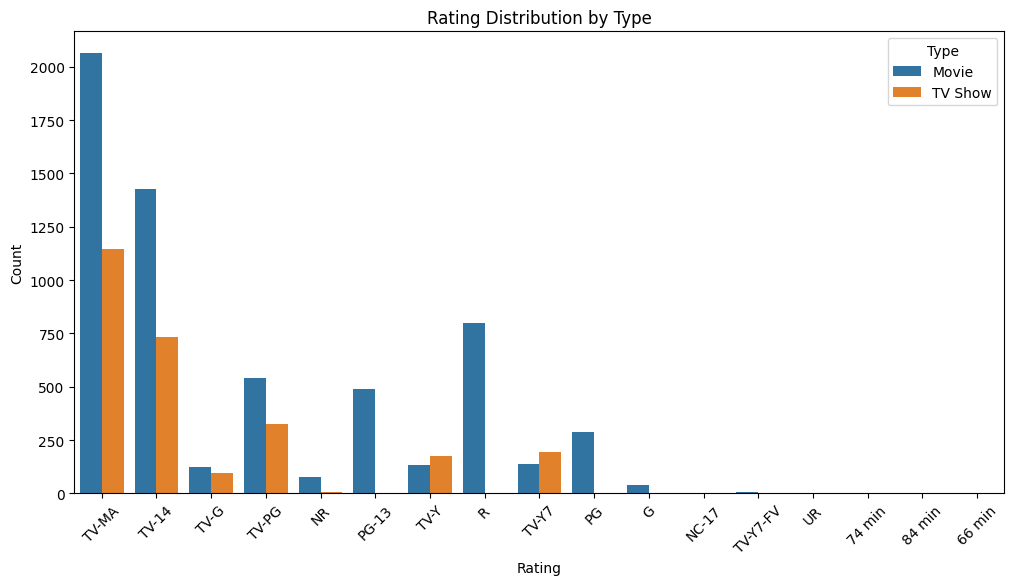

In [58]:
plt.figure(figsize=(12, 6))
grp_df = flattened_netflix_df.groupby(['title', 'rating', "type"]).size().reset_index(name='count')
sns.countplot(data=grp_df, x='rating', hue='type')
plt.title('Rating Distribution by Type')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.show()

<span style="font-size: 14px">
    <strong>Count Plot Inference</strong>
    <ul>
        <li>Graph shows the Distribution of Rating by Type</li>
        <li>TV-MA rated movies are included more in Netflix</li>
        <li>Same like Movies, TV-MA rated TV Shows are included more in Netflix</li>
    </ul>
    <strong>Action Item</strong>
    <ul>
        <li>Some rating, shows are not there. Need to include as a future goal</li>
        <li>In some ratings, there is no movie at all. Need to include as a future goal</li>
    </ul>
</span>

In [59]:
grp_df = flattened_netflix_df.groupby(['title', "type"]).size().reset_index(name='count')

fig = px.pie(grp_df, names='type', title='Type Distribution in Netflix')
fig.update_layout(width=800)
fig.show()

<span style="font-size: 14px">
    <strong>Pie Chart Inference</strong>
    <ul>
        <li>Out of 100%, approximately 70% of the contents were Movies and the remaining contents were the TV Shoes</li>
    </ul>
</span>

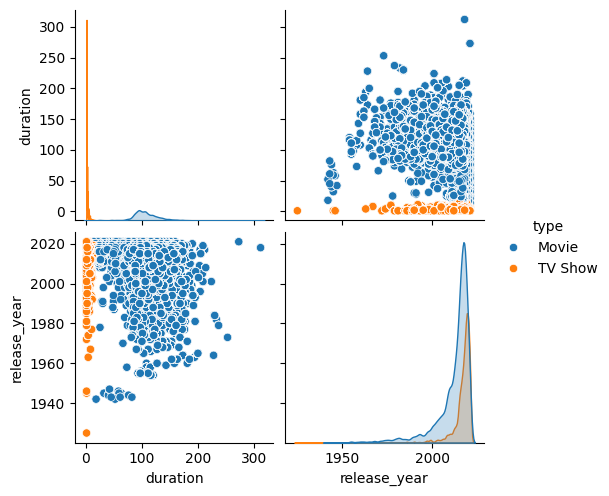

In [60]:
sns.pairplot(data=flattened_netflix_df, hue='type')

<Axes: >

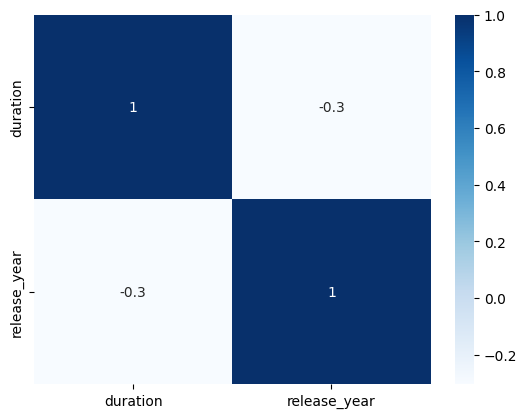

In [61]:
sns.heatmap(flattened_netflix_df[flattened_netflix_df.select_dtypes(['int', 'float']).columns].corr(), cmap="Blues", annot=True)

<span style="font-size: 14px">
    <strong>Heat Map Inference</strong>
    <ul>
        <li>Correlation between the release year and duration is negative</li>
    </ul>
</span>

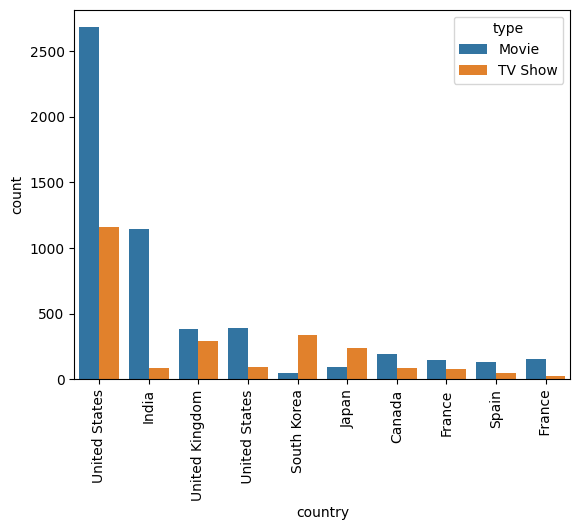

In [62]:
grp_df = flattened_netflix_df.groupby(['title', "country", "type"]).size().reset_index(name='count')
sns.countplot(data=grp_df, x='country', hue="type", order=grp_df['country'].value_counts().index[:10])
plt.xticks(rotation=90)
plt.show()

<span style="font-size: 14px">
    <strong>Count Plot Inference</strong>
    <ul>
        <li>Graph shows the Country wise Contents available in Netflix</li>
        <li>More number of Movies and TV Shows are from US</li>
        <li>Next to US, more number of movies were came from India</li>
        <li>Likewise, next to US, more number of Shows are coming from Korea</li>
    </ul>
</span>

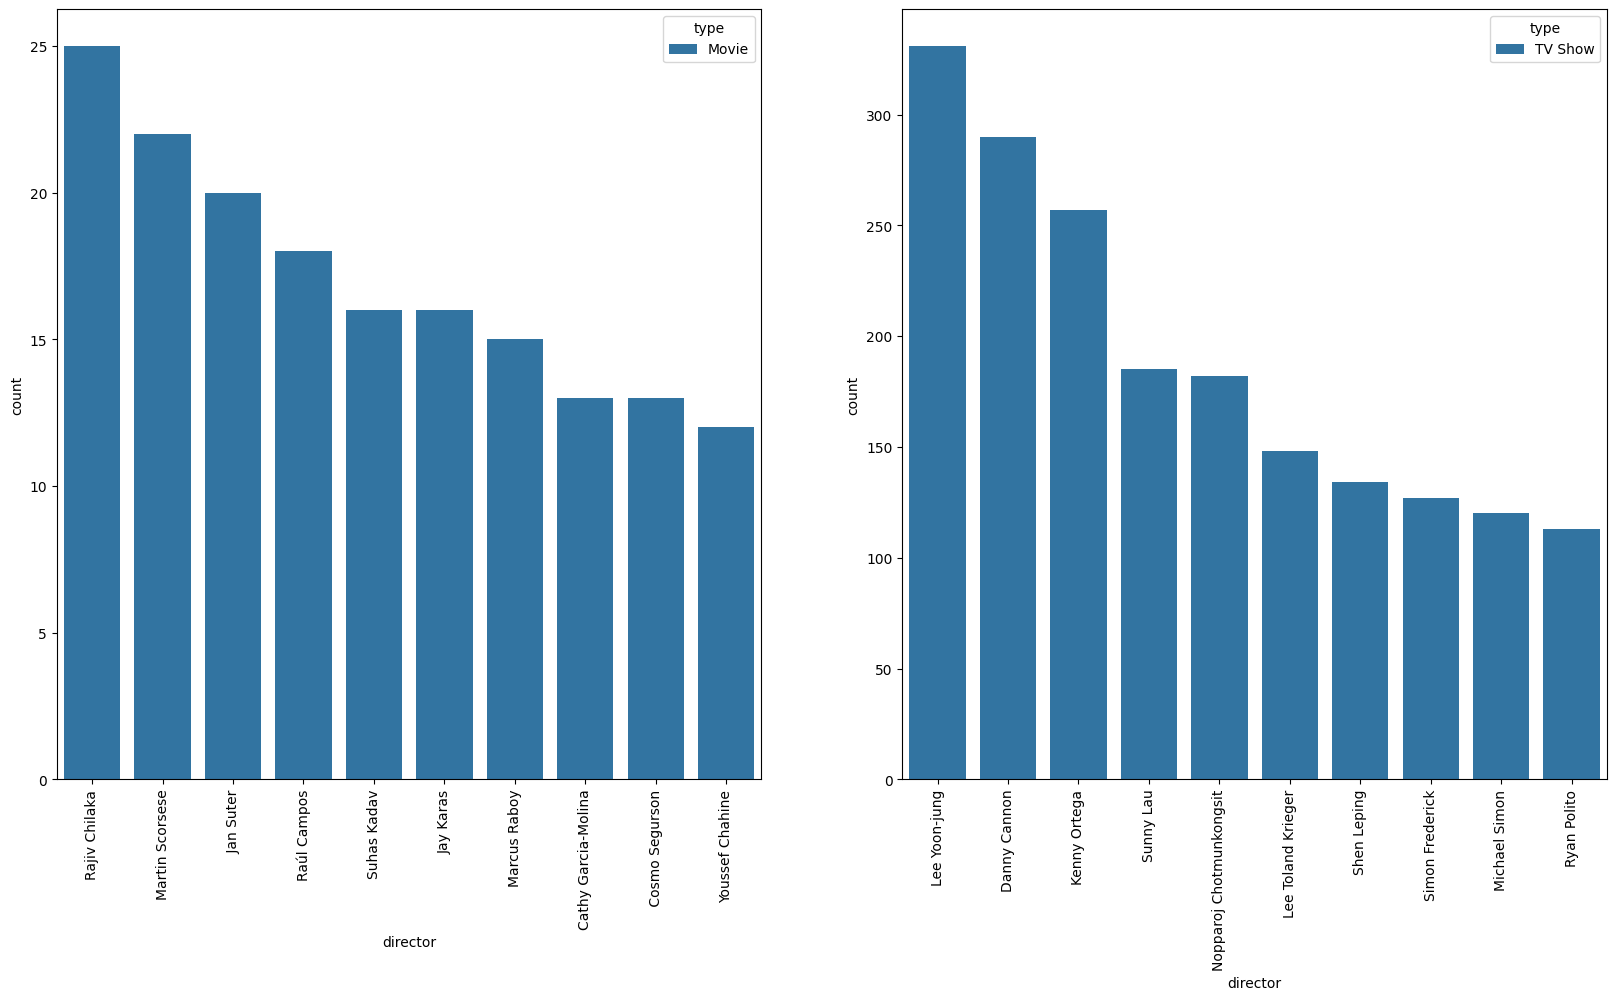

In [63]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
movies_grp_df = movies_df.groupby(['title', "director", "type"]).size().reset_index(name='count')
sns.countplot(data=movies_grp_df, x='director', hue="type", order=movies_grp_df['director'].value_counts().index[:10])
plt.xticks(rotation=90)
# plt.show()

plt.subplot(1,2,2)
shows_grp_df = shows_df.groupby(['title', "director", "type"]).size().reset_index(name='count')
sns.countplot(data=shows_grp_df, x='director', hue="type", order=shows_grp_df['director'].value_counts().index[:10])
plt.xticks(rotation=90)
plt.show()

<span style="font-size: 14px">
    <strong>Count Plot Inference</strong>
    <ul>
        <li>Graph shows the Top 10 Directors and their number of contents</li>
        <li>On Movies section, nearly 25 movies from Rajiv Chilaka were included.</li>
        <li>On TV Shows section, nearly 350 Shows from Lee Yoon-jung were included</li>
    </ul>
</span>

In [64]:
end_time = datetime.datetime.now()
total_time = end_time - start_time
minutes, seconds = divmod(total_time.total_seconds(), 60)
print(f"Total execution time: {int(minutes)} minutes and {int(seconds)} seconds")

Total execution time: 4 minutes and 40 seconds
